In [1]:
from typing import Literal
from langgraph.types import interrupt, Command
from langgraph.graph import StateGraph
from typing import TypedDict, List
from langgraph.graph import END
from main import gerar_receita_com_groq_json, carregar_prompt
from IPython.display import display, Image

from pydantic import BaseModel, Field, field_validator
from typing import Dict, Literal
import re
from langgraph.checkpoint.memory import InMemorySaver

In [2]:
class Ingredientes(BaseModel):
    principais: List[str] = Field(description="Ingredientes principais da receita")
    condimentos: List[str] = Field(description="Temperos e condimentos usados")

class Receita(BaseModel):
    descricao: str = Field(alias="Descrição", description="Breve descrição da receita")
    ingredientes: Ingredientes = Field(alias="Ingredientes", description="Ingredientes divididos por tipo")
    modo_de_preparo: Dict[str, str] = Field(alias="Modo de preparo", description="Passos numerados do preparo")
    tempo_de_preparo: str = Field(alias="Tempo de preparo", description="Tempo estimado de preparo")

    @field_validator("tempo_de_preparo")
    @classmethod
    def tempo_de_preparo_deve_ter_unidade(cls, v):
        if not isinstance(v, str):
            raise TypeError("O tempo de preparo deve ser uma string")
    
        if not re.search(r"\d+\s*(minutos|min|h|horas|dia|dias|minuto|hora|segundo|segundos)", v.lower()):
            raise ValueError("O tempo de preparo deve conter uma unidade, como 'minutos' ou 'horas'")
        return v

    @field_validator("modo_de_preparo")
    @classmethod
    def modo_de_preparo_deve_ter_ordem(cls, v):
        if not v:
            raise ValueError("O modo de preparo não pode estar vazio")
        
        try:
            passos = sorted(int(k) for k in v.keys())
            if passos != list(range(len(passos))):
                raise ValueError("As etapas do modo de preparo devem começar de 0 e ser sequenciais")
        except Exception:
            raise ValueError("As chaves do modo de preparo devem ser números sequenciais (0, 1, 2...)")
        return v

    class Config:
        populate_by_name = True  # permite usar alias nos dados JSON

In [3]:
class State(TypedDict):
    llm_output: Receita
    ingredientes: str
    ja_buscou: bool


def human_approval(state: State) -> Command[Literal[END, "gerar_receita"]]:
    is_approved = interrupt(
        {
            "question": "Você aprova ou rejeita a receita?",
            # Surface the output that should be
            # reviewed and approved by the human.
            "llm_output": state["llm_output"]
        }
    )

    if is_approved == "approved":
        return Command(goto=END)
    else:
        return Command(goto="gerar_receita")

def gerar_receita(state: State) -> State:
    prompt_base = carregar_prompt("../prompt.txt")
    
    if state.get("ja_buscou", False):
        state["llm_output"] = gerar_receita_com_groq_json(ingredientes=state["ingredientes"], prompt_base=prompt_base, buscar_web=True)
        state["ja_buscou"] = True
    else:
        state["llm_output"] = gerar_receita_com_groq_json(ingredientes=state["ingredientes"], prompt_base=prompt_base, buscar_web=False)
        state["ja_buscou"] = True

    return state



graph_builder = StateGraph(State)

# Add the node to the graph in an appropriate location
# and connect it to the relevant nodes.
graph_builder.add_node("human_approval", human_approval)
graph_builder.add_node("gerar_receita", gerar_receita)

graph_builder.set_entry_point("gerar_receita")
graph_builder.add_edge("gerar_receita", "human_approval")

checkpointer = InMemorySaver()
graph = graph_builder.compile(checkpointer=checkpointer)

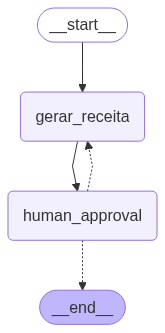

In [4]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png(max_retries=5, retry_delay=2.0)))

In [6]:
thread_config = {"configurable": {"thread_id": "seu-id"}}
result = graph.invoke({"ingredientes": "arroz, frango, cenoura"},
                      config=thread_config)

# Se interrompido, result conterá "__interrupt__"

interrupt_list = result.get("__interrupt__", None)

if interrupt_list:
    irq = interrupt_list[0]  # pegue o primeiro
    print("🚧 Interrompido! Payload:", irq.value)
    # Por exemplo:
    resposta = input("Digite 'approved' ou 'rejected': ")
    # Retome grafo com:
    new_result = graph.invoke(Command(resume=resposta), config=thread_config)
    print("Resultado final:", new_result)

🚧 Interrompido! Payload: {'question': 'Você aprova ou rejeita a receita?', 'llm_output': {'Descrição': 'Um delicioso frango com legumes ao estilo nordestino, simples e saboroso.', 'Ingredientes': {'principais': ['frango em pedaços', 'arroz lavado', 'cenoura picada', 'água'], 'condimentos': ['sal', 'pimenta-do-reino', 'alho picado', 'cebola picada', 'louro']}, 'Modo de preparo': {'0': 'Em uma panela grande, refogue a cebola e o alho picado em um pouco de azeite.', '1': 'Adicione o frango em pedaços e doure bem por todos os lados.', '2': 'Incorpore a cenoura picada e tempere com sal, pimenta-do-reino, louro e um pouco de água.', '3': 'Cubra a panela e cozinhe em fogo baixo até o frango ficar macio e a cenoura cozida (cerca de 30 minutos).', '4': 'Durante o cozimento do frango, cozinhe o arroz em água fervente com sal, de acordo com as instruções da embalagem.', '5': 'Sirva o frango com legumes sobre o arroz cozido.'}, 'Tempo de preparo': '45 minutos'}}
Resultado final: {'llm_output': {'D